In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [15]:
def f(x):
      return (3*x**2 -4*x +5)

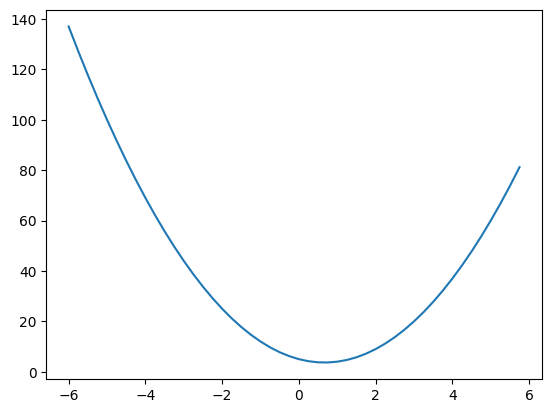

In [16]:
xs = np.arange(-6,6,0.25)
ys= f(xs)

plt.plot(xs,ys)

In [17]:
h = 0.000001
x = 2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [63]:
class Value:
        
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-1* other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [91]:
a= Value(2.0, label='a')
b= Value(-3.0, label='b')
c= Value(10.0, label='c')
e= a*b; e.label = 'e'
d= e+c; d.label = 'd'
f= Value(-2.0, label='f')

L= d*f; L.label='L'

# d = a*b +b; d.label='d'
# d._prev, d._op
# a.__mul__(b).__add__(b)


In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

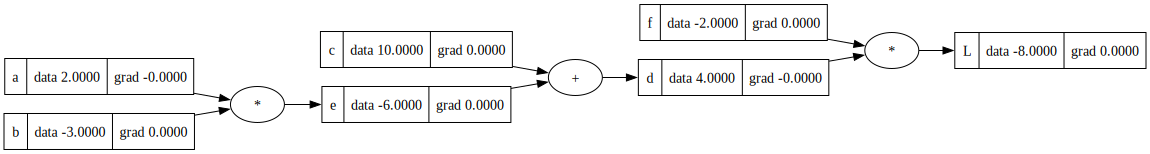

In [93]:
draw_dot(L) # L = (a*b +c)*f

In [130]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

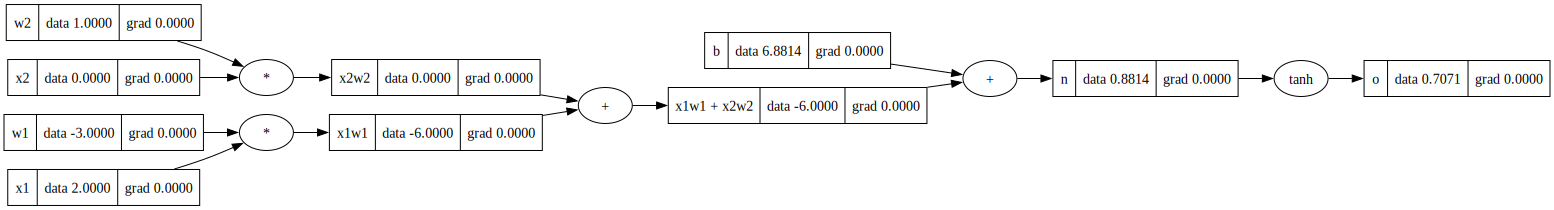

In [131]:
draw_dot(o)

In [72]:
# BACKPROPAGATION 

In [81]:
o.grad = 1

In [82]:
# o = tanh(n)
# do/dn = 1- o**2

n.grad = 1- o.data**2

In [87]:
# dn/dx1w1x2w2 = 1
# do/dx1w1x2w2 = do/dn * dn/dx1w1x2w2
x1w1x2w2.grad = n.grad * 1

# dx1w1x2w2/dx1w1 = 1
# do/dx1w1 = do/dx1w1x2w2 * dx1w1x2w2/dx1w1
x1w1.grad = x1w1x2w2.grad * 1
#similarly for x2w2
x2w2.grad = x1w1x2w2.grad * 1


x1.grad = w1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad


w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad



In [122]:
o.grad = 1.0

In [125]:
o._backward()

n._backward()

b._backward()
x1w1x2w2._backward()

x1w1._backward()
x2w2._backward()

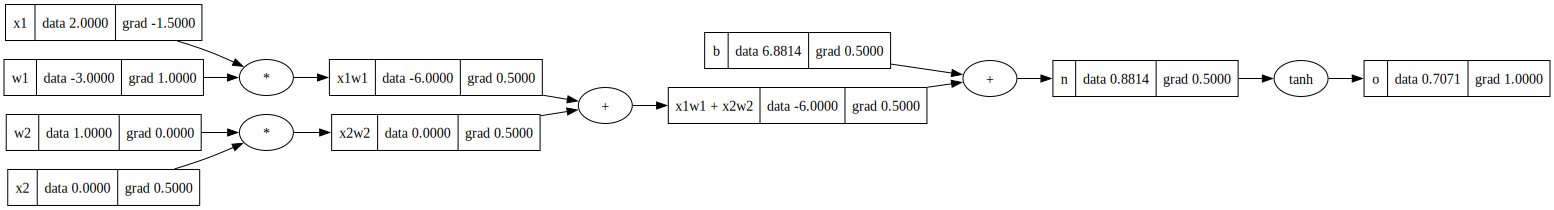

In [126]:
draw_dot(o)


In [132]:
o.backward()

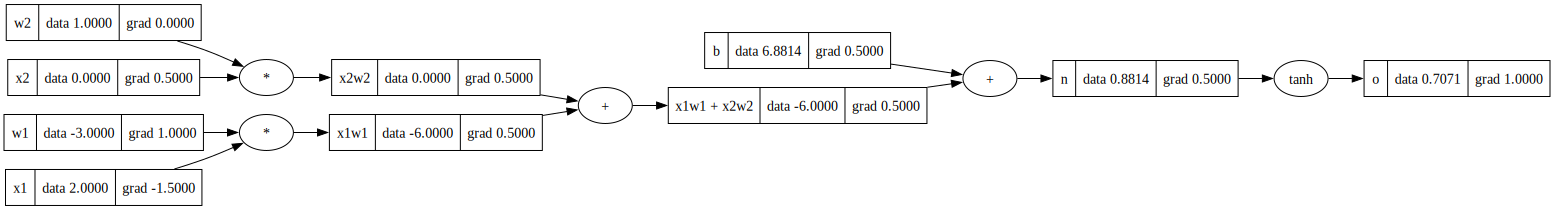

In [133]:
draw_dot(o)

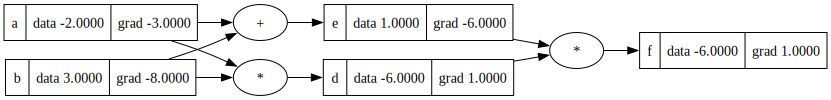

In [135]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d*e ; f.label = 'f'

f.backward()
draw_dot(f)

In [138]:
m = Value(5)
m*2

Value(data= 10)

In [1]:
# similarly he added division and exp function into value class

# all this can be done in pytorch as follows

In [11]:
import torch
import random

In [4]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [218]:

class Neuron:
      def __init__(self, nin):
            self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
            # self.b = Value(random.uniform(-1,1))
            self.b = Value(0)
      
      def __call__(self,x):
            # w*x +b
            act = sum((wi*xi for wi,xi in zip(self.w, x)) , self.b)
            out = act.tanh()
            return out
      
      def parameters(self):
            return self.w + [self.b]

class Layer:
      def __init__(self, nin, nout):
            self.neurons = [Neuron(nin) for _ in range(nout)]
            
      def __call__(self, x):
            outs = [n(x) for n in self.neurons]
            return outs[0] if len(outs)==1 else outs
      
      def parameters(self):
            # params = []
            # for neuron in self.neurons:
            #       params.extend(neuron.parameters())
            # return params
            return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
      def __init__(self, nin, nouts):
            sz = [nin] + nouts
            self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
            
      def __call__(self, x):
            for layer in self.layers:
                  x = layer(x)
            return x
      
      def parameters(self):
            return [p for layer in self.layers for p in layer.parameters()]
      

In [219]:
n = MLP(3, [4, 4, 1])

In [223]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [226]:
for k in range(20):
      
      #forward pass
      ypred = [n(x) for x in xs]
      loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
      
      #backward pass
      for p in n.parameters(): # .zero_grad() before .backward()
            p.grad = 0.0 # otherwise on training the grads will just added to older ones, so it should be reset to 0
      loss.backward()
      
      #update
      learningrate = 0.01
      for p in n.parameters():
            p.data += -learningrate * p.grad
      
      print(k, loss.data)
      
      

0 0.0008126446530349311
1 0.0008022171718161215
2 0.000792085783729002
3 0.000782237850270526
4 0.0007726614470659365
5 0.000763345313941981
6 0.0007542788091409465
7 0.0007454518672798299
8 0.0007368549607011752
9 0.0007284790639003455
10 0.0007203156207465716
11 0.0007123565142448126
12 0.0007045940386111683
13 0.000697020873457497
14 0.0006896300599015783
15 0.0006824149784367977
16 0.0006753693284119016
17 0.0006684871089854959
18 0.0006617626014329776
19 0.0006551903526948096


In [206]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.2429489637888567e-28)

In [213]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.660442316626009e-29)

In [214]:
loss.backward()

In [212]:
#gradient descent
learningrate = 0.01
for p in n.parameters():
      p.data += -learningrate * p.grad

In [210]:
# draw_dot(loss)

In [215]:
ypred

[Value(data=0.9999999999999989),
 Value(data=-0.9999999999999934),
 Value(data=0.9999999999999989),
 Value(data=0.9999999999999989)]

In [ ]:
for k in range(20):
      
      #forward pass
      ypred = [n(x) for x in xs]
      loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
      
      #backward pass
      loss.backward()
      
      #update
      learningrate = 0.01
      for p in n.parameters():
            p.data += -learningrate * p.grad
      
      print(k, loss.data)
      
      